In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import xgboost as xgb

In [40]:
def prediction(df_name, prediction_year, lower_percentile, upper_percentile, plot=False):
    df = pd.read_csv(f"data/{df_name}.csv")
    recent_year = df["year"].max()
    df["date"] = pd.to_datetime(df["date"], format='%Y-%m-%d')
    df['count_diff'] = df['count'].diff().dropna()

    for variable in ["count_diff", "Temp", "Flow", "Level"]:
        for n in range(31, 34):
            df[f"{variable}_lag_{n}"] = df[f"{variable}"].shift(n)
    
    for col in df.columns[df.isna().any()].tolist():
        df[col] = df[col].fillna(df[col].median())
    
    df = df[df["month"].isin([4, 5, 6, 7, 8])]
    train = df[df["year"] < prediction_year]
    test = df[df["year"] >= prediction_year]
    
    df = df[[col for col in df.columns if "Level" not in col]]
    use_for_feats = [col for col in df.columns[7:] if col != "count_diff"]

    X_train, y_train = train[use_for_feats], train['count_diff']
    X_test = test[use_for_feats]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    alpha_vals = np.arange(0.1, 1.0, 0.05)
    best_alpha = None
    best_score = float('inf')
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    for alpha in alpha_vals:
        lasso = Lasso(alpha=alpha)
        scores = []
        for train_index, val_index in tscv.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
            lasso.fit(X_train_fold, y_train_fold)
            y_pred = lasso.predict(X_val_fold)
            rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
            scores.append(rmse)
        avg_score = np.mean(scores)
        if avg_score < best_score:
            best_score = avg_score
            best_alpha = alpha

    lasso = Lasso(alpha=best_alpha)
    lasso.fit(X_train_scaled, y_train)
    selected_features = SelectFromModel(lasso, prefit=True).get_support()
    selected_feature_names = X_train.columns[selected_features]

    X_train_selected = X_train[selected_feature_names]
    X_test_selected = X_test[selected_feature_names]

    X_train_selected_scaled = scaler.fit_transform(X_train_selected)
    X_test_selected_scaled = scaler.transform(X_test_selected)

    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
    model.fit(X_train_selected_scaled, y_train)
    preds = model.predict(X_test_selected_scaled)

    test["pred"] = preds
    test["pred_adjust"] = test["pred"].apply(lambda x: 0 if x <= 0 else x)

    total_percentage = test["pred_adjust"].sum()
    test["pred_adjust_cumulative_percentage"] = (test["pred_adjust"] / total_percentage).cumsum() * 100

    result_df = test[(test["pred_adjust_cumulative_percentage"] >= lower_percentile) & (test["pred_adjust_cumulative_percentage"] <= upper_percentile)]
    start_date_ts = result_df.iloc[0]['date']
    end_date_ts = result_df.iloc[-1]['date']

    start_date_str = result_df["date"].iloc[0].strftime("%Y-%m-%d")
    end_date_str = result_df["date"].iloc[-1].strftime("%Y-%m-%d")

    if plot:
        df_plot = test.copy()
        df_plot = df_plot[df_plot["year"] == prediction_year]
        df_plot = df_plot.set_index("date")
        plt.figure(figsize=(10, 6))
        plt.plot(df_plot.index, df_plot['pred_adjust'], label='Prediction', color='red')

        plt.title(f'Prediction and Adjusted Prediction Over Time In {prediction_year}')
        plt.axvline(x=start_date_ts, color='blue', linestyle='--', linewidth=2, alpha=0.7)
        plt.axvline(x=end_date_ts, color='blue', linestyle='--', linewidth=2, alpha=0.7)

        plt.xlabel('Date')
        plt.ylabel('Count of Salmon')

        plt.legend()
        plt.show()

    print(f"{lower_percentile}% to {upper_percentile}% of salmon are predicted to be tagged between: {start_date_str} to {end_date_str}.")

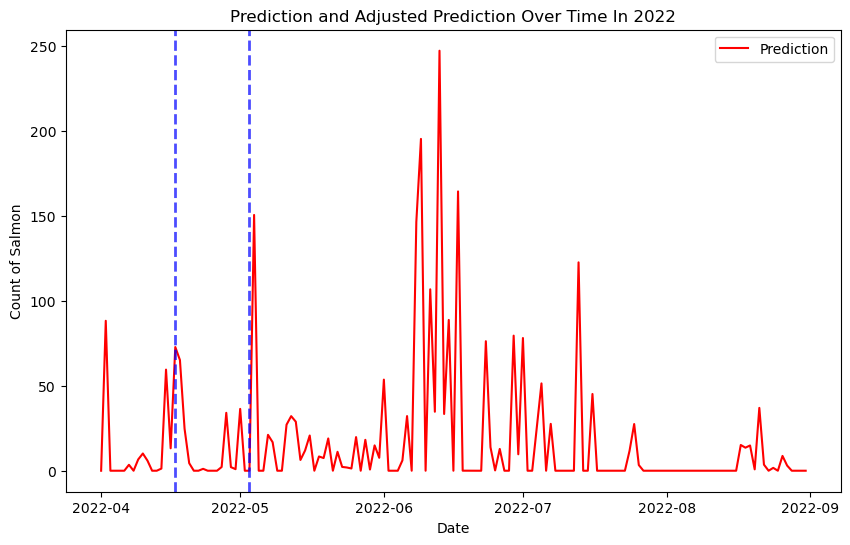

5% to 10% of salmon are predicted to be tagged between: 2022-04-17 to 2022-05-03.


In [41]:
prediction('jenny/preprocessed_ck', 2022, 5, 10, True)